In [ ]:
#Configuro el Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Importo las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
from ipywidgets import interact
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importo los datos
data = pd.read_excel('/content/gdrive/MyDrive/Maestria/Segundo Semestre/Metodos Estadisticos Avanzados/ACCIONES.xlsx', index_col=0)
data.head()

,MICROSOFT,AAPL,FORD,TESLA,SANDP,CPI,INDPRO,M1SUPPLY,CCREDIT,BMINUSA,USTB3M,USTB10Y
Date,,,,,,,,,,,,
1986-03-01,0.10,0.13,4.98,0.0,238.90,108.8,56.54,624.3,606.80,1.50,6.76,7.78
1986-04-01,0.11,0.14,4.60,0.0,235.52,108.6,56.57,647.0,614.37,1.40,6.24,7.30
1986-05-01,0.12,0.17,4.90,0.0,247.35,108.9,56.69,645.7,621.92,1.20,6.33,7.71
1986-06-01,0.11,0.16,5.03,0.0,250.84,109.5,56.50,662.8,627.89,1.21,6.40,7.80
1986-07-01,0.10,0.14,4.88,0.0,236.12,109.5,56.81,673.4,633.61,1.28,6.00,7.30


In [ ]:
##Defino la función LogDiff que me permite sacar el logaritmo de los datos que escoja
def LogDiff(x):
    x_diff = 100*np.log(x/x.shift(1))
    x_diff = x_diff.dropna()
    return x_diff

In [ ]:
#Hago una transformación de datos restando el dato del año anterior. Algunos datos con escala logarítmica, otros no.
data = pd.DataFrame({'dspread' : data['BMINUSA'] - \
data['BMINUSA'].shift(1),
'dcredit' : data['CCREDIT'] - \
data['CCREDIT'].shift(1),
'dprod' : data['INDPRO'] - \
data['INDPRO'].shift(1),
'raapl' : LogDiff(data['AAPL']),
'rsandp' : LogDiff(data['SANDP']),
'dmoney' : data['M1SUPPLY'] - \
data['M1SUPPLY'].shift(1),
'inflation' : LogDiff(data['CPI']),
'term' : data['USTB10Y'] - data['USTB3M'],
'dinflation' : LogDiff(data['CPI']) - \
LogDiff(data['CPI']).shift(1),
'mustb3m' : data['USTB3M']/12,
'rterm' : (data['USTB10Y'] - data['USTB3M']) - \
(data['USTB10Y'] - data['USTB3M']).shift(1),
'eraapl' : LogDiff(data['AAPL']) - \
data['USTB3M']/12,
'ersandp' : LogDiff(data['SANDP']) - \
data['USTB3M']/12})

In [ ]:
#Reviso como quedo mi nuevo data set
data.head()

,dspread,dcredit,dprod,raapl,rsandp,dmoney,inflation,term,dinflation,mustb3m,rterm,eraapl,ersandp
Date,,,,,,,,,,,,,
1986-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.02,NaN,0.563333,NaN,NaN,NaN
1986-04-01,-0.10,7.57,0.03,7.410797,-1.424922,22.7,-0.183993,1.06,NaN,0.520000,0.04,6.890797,-1.944922
1986-05-01,-0.20,7.55,0.12,19.415601,4.900850,-1.3,0.275862,1.38,0.459855,0.527500,0.32,18.888101,4.373350
1986-06-01,0.01,5.97,-0.19,-6.062462,1.401095,17.1,0.549452,1.40,0.273590,0.533333,0.02,-6.595796,0.867761
1986-07-01,0.07,5.72,0.31,-13.353139,-6.047514,10.6,0.000000,1.30,-0.549452,0.500000,-0.10,-13.853139,-6.547514


In [ ]:


#Genero un funcion que me permita calcular los modelos el RSS, el R2 y el BIC
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = 'eraapl ~ {}'.format(X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with lowest R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

In [ ]:
##Ahora lo que vamos a hacer es correr el codigo anterior buscando el mejor modelo que me arroje el menor RSS con dos variables

X = data.drop(data[['eraapl', "raapl", "rsandp", "inflation", "term"]], axis=1)
y = data['eraapl']

# Establezco el número de predictores de cada subset en 2
k = 2

# Get all possible models in subset
subset = get_models(2, X, y)

# Display results
print('This model yields the lowest RSS score for the subset of models with {} predictors:'.format(k))
display(min_rss(subset))

print('This model yields the highest adjusted R-squared score for the subset of models with {} predictors:'.format(k))
max_adjr2(get_models(2, X, y))

This model yields the lowest RSS score for the subset of models with 2 predictors:


('eraapl ~ dmoney + ersandp',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fbe9470f400>)

This model yields the highest adjusted R-squared score for the subset of models with 2 predictors:


('eraapl ~ dmoney + ersandp',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fbe94648a90>)

Se observa que el modelo que menor RSS y mayor R2 es en el que se incluyen las variables de dmoney y ersandp donde el modelo estaria definido de la forma: $$eraapl = dmoney + ersandp$$

In [ ]:
X_combos = itertools.combinations(list(X.columns), 3)

In [ ]:
#Ahora vamos a coger un subset de Predictores, eliminando 5 variables en las cuales tengo en cuenta mi variable dependiente
X = data.drop(data[['eraapl', "raapl", "rsandp", "inflation", "term"]], axis=1)
y = data['eraapl']

In [ ]:
# Obtengo todos los resultados de mis modelos teniendo en cuenta las 8 variables predictoras
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done
Progess: k = 7, done
Progess: k = 8, done


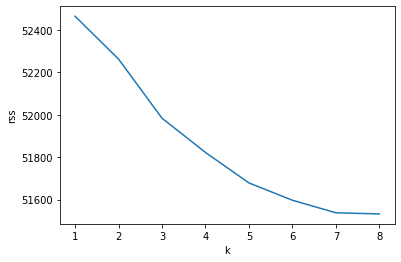

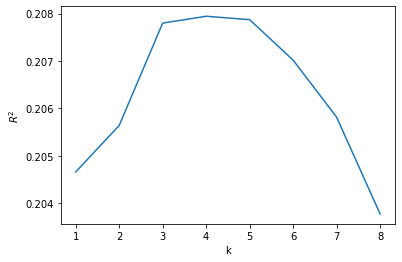

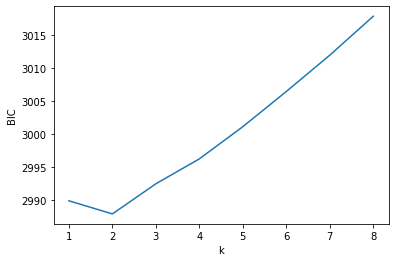

In [ ]:
# Obtenemos el mejor rss para cada subset
rss   = [min_rss(m)[1].ssr for m in model_subsets]

# Calculamos tambien el mejor R2 para cada subset de datos
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

k     = np.arange(1, len(rss)+1)


# Obtenemos el mejor criterio bayesiano
def min_bic(statsmodels):
    """Return model with lowest R-squared"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

bic = [min_bic(m)[1].bic for m in model_subsets]


ax = sns.lineplot(x=k, y=rss)
plt.xlabel('k')
plt.ylabel('rss')
plt.show()

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.show()

sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

De estas graficas podemos concluir que la cantidad de predictores donde obtenemos las mejores estadisticas es cuando tenemos 4 o 5 predictores, en el caso de 5 tiene un ligero R2 menor a el que se obtienen con 4 pero su RSS es mucho menor por lo que se puede concluir que se deberian escoger 5 predictores para el modelo, aunque el BIC nos muestra que el numero deberia ser 2. Otra anotación importante que cabe destacar es que el R2 obtenido no es el mejor pero teniendo en cuenta mis variables predictoras y la naturaleza d elos datos de la renta variable es un resultado aceptable.

In [ ]:
#Ahora lo que buscamos determinar es cuales son las variables que me minimizan el RSS, me maximizan el R2 y me minimizan el BIC
best_subset_rrs = list(min_rss(model_subsets[4])[1].params.index)[1:]
print(best_subset_rrs)
best_subset_r2 = list(max_adjr2(model_subsets[4])[1].params.index)[1:]
print(best_subset_r2)
best_subset_bic = list(min_bic(model_subsets[4])[1].params.index)[1:]
print(best_subset_bic)

['dcredit', 'dmoney', 'dinflation', 'mustb3m', 'ersandp']
['dcredit', 'dmoney', 'dinflation', 'mustb3m', 'ersandp']
['dcredit', 'dmoney', 'dinflation', 'mustb3m', 'ersandp']


Vemos que las variables optimas para 5 predictores son las mismas y estas son
'dcredit', 'dmoney', 'dinflation', 'mustb3m', 'ersandp'

##Ahora vamos a hacer la selección por medio de los metodos de Forward and Backward Stepwise Selection

In [ ]:
#Ahora calculamos con el metodo de Foward and Backward Stepwise Selection
def scale(df):
    """Xi = Xi - mu(Xi) / σ(Xi)"""
    return (df-df.mean())/(df.std())


def forward_stepwise(X, y, results=[(0, [])]):
    """Perform forward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.207)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds}).drop(0).reset_index()
    
    # Get rss score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = 'eraapl ~ {}'.format('+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, [p]+p_used)]
    
    # Choose predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    # Recursive call to self
    return forward_stepwise(X, y, new_results)


def backward_stepwise(X, y, results=[]):
    """Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = 'eraapl ~ {}'.format('+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        return backward_stepwise(X, y, [(model.ssr, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = 'eraapl ~ {}'.format('+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, p_test)]
    
    # Choose removal of predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    return backward_stepwise(X, y, new_results)

In [ ]:
#Ahora lo que buscamos hacer es ver como varia mi RSS usando las metodologias de Forward and Backward Stepwise Selection
X = scale(X)

#Para Foward
forward_stepwise_results = forward_stepwise(X, y)
display(HTML('<h4>Forward Stepwise Selection</h4>'))
display(forward_stepwise_results)

#Para Stepwise
backward_stepwise_results = backward_stepwise(X, y)
display(HTML('<h4>Backward Stepwise Selection</h4>'))
display(backward_stepwise_results)

,index,rss,predictors
0,1,52464.338574,[ersandp]
1,2,52262.458904,"[dmoney, ersandp]"
2,3,51983.643564,"[mustb3m, dmoney, ersandp]"
3,4,51822.172724,"[dinflation, mustb3m, dmoney, ersandp]"
4,5,51678.409294,"[dcredit, dinflation, mustb3m, dmoney, ersandp]"
5,6,51596.843103,"[dprod, dcredit, dinflation, mustb3m, dmoney, ..."
6,7,51537.664899,"[dspread, dprod, dcredit, dinflation, mustb3m,..."
7,8,51532.354119,"[rterm, dspread, dprod, dcredit, dinflation, m..."


,rss,predictors
0,51532.354119,"[dspread, dcredit, dprod, dmoney, dinflation, ..."
1,51537.664899,"[dspread, dcredit, dprod, dmoney, dinflation, ..."
2,51596.843103,"[dcredit, dprod, dmoney, dinflation, mustb3m, ..."
3,51678.409294,"[dcredit, dmoney, dinflation, mustb3m, ersandp]"
4,51822.172724,"[dmoney, dinflation, mustb3m, ersandp]"
5,51983.643564,"[dmoney, mustb3m, ersandp]"
6,52262.458904,"[dmoney, ersandp]"
7,52464.338574,[ersandp]


In [ ]:
display(HTML('<h4>Comparison of methods for subset with 5 predictors</h4>'))
print('Best Subset Selection       : {}'.format(sorted(best_subset_rrs)))
print('Forward Stepwise Selection  : {}'.format(sorted(forward_stepwise_results.loc[4]['predictors'])))
print('Backward Stepwise Selection : {}'.format(sorted(backward_stepwise_results.loc[3]['predictors'])))
#Los 3 metodos escogieron los mismos 5 predictores

Best Subset Selection       : ['dcredit', 'dinflation', 'dmoney', 'ersandp', 'mustb3m']
Forward Stepwise Selection  : ['dcredit', 'dinflation', 'dmoney', 'ersandp', 'mustb3m']
Backward Stepwise Selection : ['dcredit', 'dinflation', 'dmoney', 'ersandp', 'mustb3m']


De esta manera concluimos que los 3 metodos escogieron las mismas variables independientes.

##Usando el Approach de Validación y Cross-Validation

In [ ]:
#Escogiendo el modelo usando el test de validación y el Cross-Validation
def best_subset_rss(X, y):
    """Perform best subset selection using Residual Sum of Squares to
    select best model in each subset.
    Notes: highly computationally expensive for large number of features in  X
    Maxes out my laptop for p > 14"""
    # get all model results
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))
    # Get best rss score for each subset
    return [min_rss(m) for m in model_subsets]

def mse(y_hat, y):
    """Calculate Mean Squared Error"""
    return np.sum(np.square(y_hat - y)) / y.size

In [ ]:
# CCreamos un indicie que me arrastre el 50% de los datos
np.random.seed(1)
train = np.random.rand(len(data)) < 0.5

response   = 'eraapl'

# Asignamos datos de testeo y de entrenamiento
X_train = data[train][['dspread', 'dcredit', 'dprod', 'dmoney','dinflation', 'mustb3m', 'rterm', 'ersandp']]
X_test  = data[~train][['dspread', 'dcredit', 'dprod', 'dmoney','dinflation', 'mustb3m', 'rterm', 'ersandp']]
y_train = data[train][response]
y_test  = data[~train][response]

In [ ]:
# Perform best_subset selection
best_subsets = best_subset_rss(X_train, y_train)

Best subset selected: k = 1/8, done
Best subset selected: k = 2/8, done
Best subset selected: k = 3/8, done
Best subset selected: k = 4/8, done
Best subset selected: k = 5/8, done
Best subset selected: k = 6/8, done
Best subset selected: k = 7/8, done
Best subset selected: k = 8/8, done


,predictors,MSE
0,1,147.645352
1,2,148.086438
2,3,150.239675
3,4,151.471466
4,5,150.916077
5,6,150.590985
6,7,149.287598
7,8,149.872107


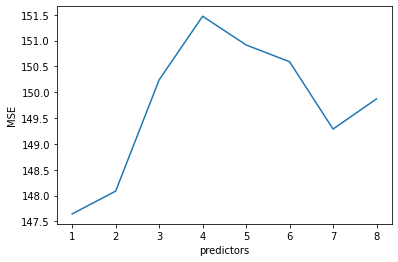

In [ ]:
# Using 50% hold out set
# Measure mean squared error for each model selected by best subset selection
MSEs = []
for m in best_subsets:
    model = m[1]
    y_hat = model.predict(X_test)
    r     = mse(y_hat, y_test)
    MSEs += [r]

results = pd.DataFrame({'predictors': np.arange(1, 9), 'MSE': MSEs})
display(results)
sns.lineplot(x='predictors', y='MSE', data=results);

Usando el 50% de los datos del dataset para calcular el error cuadratico medio observamos que la cantidad de predictores optima se encuentra entre 1 y 2 predictores

In [ ]:
# Which 2 predictors did best subset selection choose based on the TRAINING set?
best_subsets[1][0]

'eraapl ~ dmoney + ersandp'

Usando dos predictores tenemos que las variables independientes que me minimizan mi error cuadratico medio son dmoney y ersandp

In [ ]:
# Which 2 predictors does best subset selection choose based on the FULL set?
best_subsets_full = best_subset_rss(data[['dspread', 'dcredit', 'dprod', 'dmoney','dinflation', 'mustb3m', 'rterm', 'ersandp']], data['eraapl'])
best_subsets_full[1][0]

Best subset selected: k = 1/8, done
Best subset selected: k = 2/8, done
Best subset selected: k = 3/8, done
Best subset selected: k = 4/8, done
Best subset selected: k = 5/8, done
Best subset selected: k = 6/8, done
Best subset selected: k = 7/8, done
Best subset selected: k = 8/8, done


'eraapl ~ dmoney + ersandp'

De aca podemos concluir que ambos modelos usan los mismos predictores

In [ ]:
#Ahora lo observamos con el metodo del Cross validation
def cross_val(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return (MSEs, formula)

In [ ]:
# Get best subsets of predictors for full dataset

best_subsets_full = best_subset_rss(X, y)

Best subset selected: k = 1/8, done
Best subset selected: k = 2/8, done
Best subset selected: k = 3/8, done
Best subset selected: k = 4/8, done
Best subset selected: k = 5/8, done
Best subset selected: k = 6/8, done
Best subset selected: k = 7/8, done
Best subset selected: k = 8/8, done


In [ ]:
# Perform cross validation for each subset of predictors
results = []
for sub in best_subsets_full:
    results += [cross_val(sub[0], X, y, 10)]

results_a_df = pd.DataFrame({'predictors': list(np.arange(1, 9)),
                           'MSE_mean': [np.mean(i[0]) for i in results],
                           'MSE_folds': [i[0] for i in results],
                           'Model': [i[1] for i in results]})
display(results_a_df)


,predictors,MSE_mean,MSE_folds,Model
0,1,138.786992,"[93.34089851119352, 136.62664761202365, 166.32...",eraapl ~ ersandp
1,2,138.414434,"[93.26174179909769, 136.1113925110296, 166.889...",eraapl ~ dmoney + ersandp
2,3,138.361890,"[100.57355660618944, 133.84036639075498, 165.5...",eraapl ~ dmoney + mustb3m + ersandp
3,4,138.444514,"[96.66872449335831, 133.0443013826184, 165.171...",eraapl ~ dmoney + dinflation + mustb3m + ersandp
4,5,138.309037,"[95.72647725152626, 132.11623375002893, 164.77...",eraapl ~ dcredit + dmoney + dinflation + mustb...
5,6,138.574721,"[95.49744738534642, 135.48184403718113, 164.49...",eraapl ~ dcredit + dprod + dmoney + dinflation...
6,7,138.869012,"[95.2918366737041, 134.86022564160115, 163.733...",eraapl ~ dspread + dcredit + dprod + dmoney + ...
7,8,139.752867,"[97.57903051590786, 135.32157956864924, 165.57...",eraapl ~ dspread + dcredit + dprod + dmoney + ...


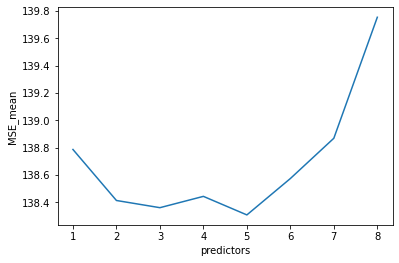

In [ ]:
sns.lineplot(x='predictors', y='MSE_mean', data=results_a_df);

In [ ]:
best_subset_choice = results_a_df[results_a_df['MSE_mean'] == results_a_df['MSE_mean'].min()]
display(best_subset_choice)

best_subset_choice['Model'].iloc[0]

,predictors,MSE_mean,MSE_folds,Model
4,5,138.309037,"[95.72647725152626, 132.11623375002893, 164.77...",eraapl ~ dcredit + dmoney + dinflation + mustb...


'eraapl ~ dcredit + dmoney + dinflation + mustb3m + ersandp'

De este resultado observamos que con 5 predictores obtenemos el minimo de los errores cuadraticos medioscon un MSE 138.309037

,rss,predictors,predictor_count
0,51532.354119,"[dspread, dcredit, dprod, dmoney, dinflation, ...",1
1,51537.664899,"[dspread, dcredit, dprod, dmoney, dinflation, ...",2
2,51596.843103,"[dcredit, dprod, dmoney, dinflation, mustb3m, ...",3
3,51678.409294,"[dcredit, dmoney, dinflation, mustb3m, ersandp]",4
4,51822.172724,"[dmoney, dinflation, mustb3m, ersandp]",5
5,51983.643564,"[dmoney, mustb3m, ersandp]",6
6,52262.458904,"[dmoney, ersandp]",7
7,52464.338574,[ersandp],8


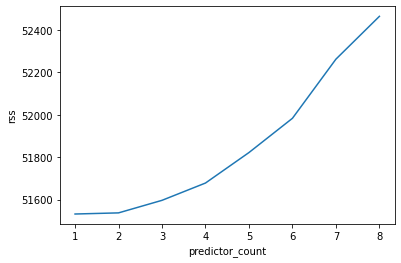

In [ ]:
#Volvemos a correr un Backwards Stepwise con todos los features
backward_stepwise_subsets = backward_stepwise(X, y)
backward_stepwise_subsets['predictor_count'] = np.arange(1, 9)
display(backward_stepwise_subsets)

sns.lineplot(x='predictor_count', y='rss', data=backward_stepwise_subsets);

Podemos concluir que un punto de inflexión en el rss se obtiene cuando en el modelo se incluyen 5 variables independientes pero se obtiene el mejor resultado usando 7 u 8 predictores en el modelo

In [ ]:
# Perform cross validation for each subset of predictors
results = []
for preds in backward_stepwise_subsets['predictors']:
    f = 'eraapl ~ {}'.format(' + '.join(preds))
    results += [cross_val(f, X, y, 10)]

results_b_df = pd.DataFrame({'predictors': list(np.arange(1, len(results)+1)),
                           'MSE_mean': [np.mean(i[0]) for i in results],
                           'MSE_folds': [i[0] for i in results],
                           'Model': [i[1] for i in results]})
display(results_b_df)


,predictors,MSE_mean,MSE_folds,Model
0,1,139.752867,"[97.57903051590786, 135.32157956864924, 165.57...",eraapl ~ dspread + dcredit + dprod + dmoney + ...
1,2,138.869012,"[95.2918366737041, 134.86022564160115, 163.733...",eraapl ~ dspread + dcredit + dprod + dmoney + ...
2,3,138.574721,"[95.49744738534642, 135.48184403718113, 164.49...",eraapl ~ dcredit + dprod + dmoney + dinflation...
3,4,138.309037,"[95.72647725152626, 132.11623375002893, 164.77...",eraapl ~ dcredit + dmoney + dinflation + mustb...
4,5,138.444514,"[96.66872449335831, 133.0443013826184, 165.171...",eraapl ~ dmoney + dinflation + mustb3m + ersandp
5,6,138.361890,"[100.57355660618944, 133.84036639075498, 165.5...",eraapl ~ dmoney + mustb3m + ersandp
6,7,138.414434,"[93.26174179909769, 136.1113925110296, 166.889...",eraapl ~ dmoney + ersandp
7,8,138.786992,"[93.34089851119352, 136.62664761202365, 166.32...",eraapl ~ ersandp


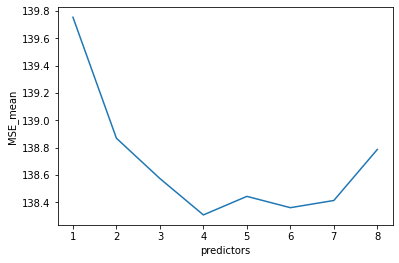

In [ ]:
sns.lineplot(x='predictors', y='MSE_mean', data=results_b_df);

Podemos observar que para una cantidad de 5 predictores es donde encontramos el valor minimo de el error cuadratico medio de 138.309037, usando los mismos 5 precitores que encontramos en las metodologias anteriores eraapl ~ dcredit + dmoney + dinflation + mustb3m + ersandp

In [ ]:
display(HTML('</br><h4>Best Subset Selection from 10 predictors, with 10-fold Cross Validation</h4>'))
best_subset_choice = results_a_df[results_a_df['MSE_mean'] == results_a_df['MSE_mean'].min()]
display(best_subset_choice)
print(best_subset_choice['Model'].iloc[0])

display(HTML('</br><h4>Backward Stepwise Selection from all 10 predictors, with 10-fold Cross Validation</h4>'))
backward_select_choice = results_b_df[results_b_df['MSE_mean'] == results_b_df['MSE_mean'].min()]
display(backward_select_choice)
print(backward_select_choice['Model'].iloc[0])

,predictors,MSE_mean,MSE_folds,Model
4,5,138.309037,"[95.72647725152626, 132.11623375002893, 164.77...",eraapl ~ dcredit + dmoney + dinflation + mustb...


eraapl ~ dcredit + dmoney + dinflation + mustb3m + ersandp


,predictors,MSE_mean,MSE_folds,Model
3,4,138.309037,"[95.72647725152626, 132.11623375002893, 164.77...",eraapl ~ dcredit + dmoney + dinflation + mustb...


eraapl ~ dcredit + dmoney + dinflation + mustb3m + ersandp


#Encogimiento

In [ ]:
#Ahora  una regresion Ridge y Lasso
#En este caso vamos a usar una regresion ridge con un cros validation de 10 particiones para producir resultados comparables a los que se obtuvieron anteriormente

In [ ]:
def ridge_cv(X, y, λ, k):
    """Perform ridge regresion with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Ridge(alpha=λ, fit_intercept=False, solver='cholesky').fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

In [ ]:
X.dropna(inplace=True)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(383, 13)

In [ ]:
data.head()

,dspread,dcredit,dprod,raapl,rsandp,dmoney,inflation,term,dinflation,mustb3m,rterm,eraapl,ersandp
Date,,,,,,,,,,,,,
1986-05-01,-0.20,7.55,0.12,19.415601,4.900850,-1.3,0.275862,1.38,0.459855,0.527500,0.32,18.888101,4.373350
1986-06-01,0.01,5.97,-0.19,-6.062462,1.401095,17.1,0.549452,1.40,0.273590,0.533333,0.02,-6.595796,0.867761
1986-07-01,0.07,5.72,0.31,-13.353139,-6.047514,10.6,0.000000,1.30,-0.549452,0.500000,-0.10,-13.853139,-6.547514
1986-08-01,0.18,6.90,-0.08,19.415601,6.877262,5.0,0.182482,1.48,0.182482,0.474167,0.18,18.941435,6.403095
1986-09-01,-0.15,9.38,0.12,-12.516314,-8.931074,6.1,0.454753,2.10,0.272271,0.445833,0.62,-12.962148,-9.376907


In [ ]:
X = data.drop(data[['eraapl', "raapl", "rsandp", "inflation", "term"]], axis=1)
y = data['eraapl']

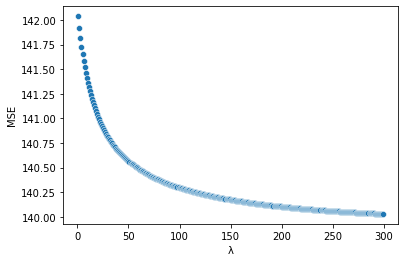

In [ ]:
#lambdas = np.arange(0, 0.08, 0.0005)
lambdas = np.arange(1, 300, 1)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(ridge_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [ ]:
min(zip(MSEs, lambdas))

(140.0293645775075, 299)

Aca podemos observar que el resultado obtenido es peor en comparación a los anteriores ya que encontramos que el obtenemos el menor error cuadratico medio cuando tenemos un λ=299 para obtener un MSE = 140.029


(array([-0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ]),
 [Text(-0.5, 0, '−0.50'),
  Text(-0.25, 0, '−0.25'),
  Text(0.0, 0, '0.00'),
  Text(0.25, 0, '0.25'),
  Text(0.5, 0, '0.50'),
  Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.00'),
  Text(1.25, 0, '1.25'),
  Text(1.5, 0, '1.50')])

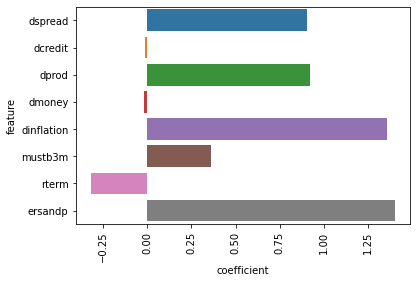

In [ ]:
# What coefficients does ridge regression choose for the optimal lambda value?
model = linear_model.Ridge(alpha=7, fit_intercept=False, solver='cholesky').fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)

Se observa como la mayoria de las variables tienen un aporte positivo gracias a su coeficiente, estas son ersandp, dinflation, dprod, dspread

In [ ]:
#Ahora veremos el mismo enfoque con un mismo CV de 10 particiones pero con una regresion Lasso

In [ ]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = linear_model.Lasso(alpha=λ, copy_X=True, fit_intercept=False, max_iter=10000,
                                    positive=False, precompute=False, random_state=None,
                                   selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse(y_hat, y_test)]
    return MSEs

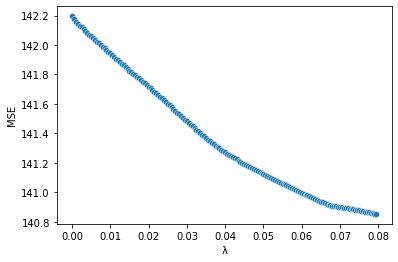

In [ ]:
X = data.drop(data[['eraapl', "raapl", "rsandp", "inflation", "term"]], axis=1)
y = data['eraapl']

#lambdas = np.arange(0, 0.08, 0.0005)

lambdas = np.arange(0, 0.08, 0.0005)
MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X, y, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}));

In [ ]:
min(zip(MSEs, lambdas))

(140.8527450777186, 0.0795)

Con la regresión Lasso por su parte obtenemos un λ =0.0795 el cual me minimiza el error cuadratico medio, un resultado similar al que obtenemos en el caso de ridge.

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ]),
 [Text(-1.0, 0, '−1.0'),
  Text(-0.5, 0, '−0.5'),
  Text(0.0, 0, '0.0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(1.5, 0, '1.5'),
  Text(2.0, 0, '2.0'),
  Text(2.5, 0, '2.5'),
  Text(3.0, 0, '3.0')])

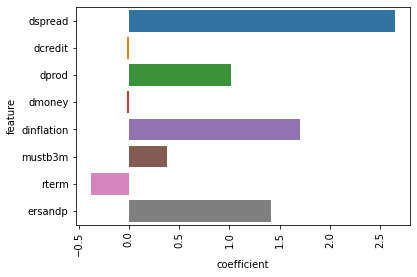

In [ ]:
# What coefficients does the lasso choose for the optimal lambda value?
model = linear_model.Lasso(alpha=0.002, copy_X=True, fit_intercept=False, max_iter=10000, positive=False, precompute=False, random_state=None,
                           selection='cyclic', tol=0.0001, warm_start=False).fit(X, y)
df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_})
ax = sns.barplot(x='coefficient', y='feature', data=df);
plt.xticks(rotation=90)

In [ ]:
display(HTML('<h4>Model chosen by lasso:</h4>'))
print('Salary ~ {}'.format(' + '.join(X.columns[model.coef_ != 0])))
print('MSE: {:01.0f}'.format(min(MSEs)))

display(HTML('<h4>Model chosen by backward stepwise selection:</h4>'))
print(backward_select_choice['Model'].iloc[0])
print('MSE: {:01.0f}'.format(backward_select_choice['MSE_mean'].iloc[0]))

Salary ~ dspread + dcredit + dprod + dmoney + dinflation + mustb3m + rterm + ersandp
MSE: 141


eraapl ~ dcredit + dmoney + dinflation + mustb3m + ersandp
MSE: 138


Se puede observar como mediante el metodo de backward stepwise pudmos obtener un modelo mucho más simple que es superior al modelo que me entrega la regresión de Lasso o Ridge ya que con menos variables obtiene un menor error cuadratico medio.

#Reducción de dimensionalidad

##Regresiones PCR y PSL

In [ ]:
#Reducción de dimensionalidad Regresion de componentes principales y PSL
# Deps for pca/pcr
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [ ]:
X = data.drop(data[['eraapl', "raapl", "rsandp", "inflation", "term"]], axis=1)
y = data['eraapl']

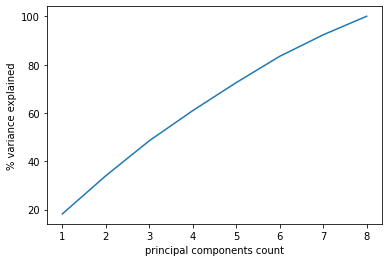

In [ ]:
#PCA
# Get principle components
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

# What variance (%c umulative) is explained by principle components?
variance_explained   = np.cumsum(np.around(pca.explained_variance_ratio_ *100, decimals=1))
principal_components = np.arange(1, len(variance_explained)+1)

sns.lineplot(x='principal components count', y='% variance explained', 
             data=pd.DataFrame({'principal components count': principal_components, 
                                '% variance explained': variance_explained}));

In [ ]:
X_reduced = pca.fit_transform(scale(X))
X_reduced.shape

(383, 8)

Se ve como existe un incremento lineal entre el número de componentes principales y la varianza explicada por cada uno de estos, un punto optimo de componentes principales esperando que estos expliqen el 90% o mas es usando 7 componentes principales

In [ ]:
#Regresion de componentes principales
def pcr_cv(seed, cv_folds):
    """Perform Principle Component Regression evaluated with
    k-fold cross validation"""
    # Load data
    X = data.drop(data[['eraapl', "raapl", "rsandp", "inflation", "term"]], axis=1)
    y = data['eraapl']
    
    # Get all principle components
    pca = PCA()
    X_reduced = pca.fit_transform(scale(X))
    
    # Get cv MSE for cumulative components
    M = X_reduced.shape[1]
    MSEs = []
    for m in range(M):
        model = LinearRegression()
        cv    = KFold(n_splits=cv_folds, random_state=seed, shuffle=True)
        cv10  = cross_val_score(model, X_reduced[:, 0:m+1], y, cv=cv, scoring='neg_mean_squared_error')
        MSEs += [np.mean(np.abs(cv10))]
        
    ax = sns.lineplot(x='principal components count', y='MSE', 
                 data=pd.DataFrame({'principal components count': principal_components, 
                                    'MSE': MSEs}));
    #ax.axes.set_ylim(1000, 1000)


interact(pcr_cv, 
           seed=widgets.IntSlider(min=1, max=50, step=1, value=10), 
           cv_folds=widgets.IntSlider(min=2, max=100, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), IntSlider(value=10, description=…

Aca podemos observar como varia el error cuadratico medio y la cantidad de componentes principales cuando vario el lugar donde particiono mis datos y la cantidad de particiones que voy a tomar en el Cross validation, de la grafica se observa como para la mayoria de valores de seed y particiones la cantidad de componentes principales que minimizan el error cuadratico medio es 8 aunque en algunos valores la cantidad de componentes principales que minimizan el MSE esta entre 5 y 6.

In [ ]:
def pcr_holdout(seed):
    """Perform Principle Component Regression evaluated with
    k-fold hold-out set"""
    # With 50% holdout set
    np.random.seed(seed)
    train = np.random.rand(len(data)) < 0.5
    
    pca = PCA()
    X_train = pca.fit_transform(scale(data.drop('eraapl', axis=1)[train]))
    y_train = data['eraapl'][train]
    X_test  = pca.fit_transform(scale(data.drop('eraapl', axis=1)[~train]))
    y_test  = data['eraapl'][~train]
    
    
    # Get cv MSE for cumulative components
    M = X_reduced.shape[1]
    
    MSEs = []
    for m in range(M):
        model = LinearRegression().fit(X_train[:, 0:m+1], y_train)
        y_hat = model.predict(X_test[:, 0:m+1])
        MSEs += [mse(y_hat, y_test)]
    
    # Plot results
    ax = sns.lineplot(x='principal components count', y='MSE', 
                      data=pd.DataFrame({'principal components count': principal_components, 
                                         'MSE': MSEs}))
    #ax.axes.set_ylim(10, 100);

interact(pcr_holdout, seed=widgets.IntSlider(min=1, max=50, step=1, value=10));

interactive(children=(IntSlider(value=10, description='seed', max=50, min=1), Output()), _dom_classes=('widget…

En esta grafica podemos observar como a medida que variamos donde se encuentra la partición entre mi set de entrenamiento y de testeo el número optimo de componentes principales que me minimiza el MSE varia de gran manera ya que mi variable de seed me controla la mezcla de los datos, mostrando que existe una gran variablidad en el MSE dependiendo de donde parto mis datos.